In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive/dl_coursework")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch
import copy
import utils
import decoder
import trainnet
import wavelet
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
class Decoder3(nn.Module):
    def __init__(self, k_channels, output_channels, upsample_times=4):
        super(Decoder3, self).__init__()
        self.conv1 = nn.Conv2d(k_channels, k_channels, (3,3), padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(k_channels, affine=True)
        self.conv2 = nn.Conv2d(k_channels, k_channels, (3,3), padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(k_channels, affine=True)
        self.conv3 = nn.Conv2d(k_channels, k_channels, (3,3), padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(k_channels, affine=True)
        self.conv4 = nn.Conv2d(k_channels, k_channels, (3,3), padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(k_channels, affine=True)
        if(upsample_times==5):
            self.conv_add = nn.Conv2d(k_channels, k_channels, (3,3), padding=1, bias=False)
            self.bn_add = nn.BatchNorm2d(k_channels, affine=True)
        else:
            self.conv_add = None
            self.bn_add = None
        self.conv5 = nn.Conv2d(k_channels, k_channels, (3,3), padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(k_channels, affine=True)
        self.conv6 = nn.Conv2d(k_channels, output_channels, (3,3), padding=1, bias=False)

        
    def forward(self, x):
        out = self.conv1(x)
        out = F.interpolate(out, scale_factor=2, mode='bilinear', align_corners=True)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.interpolate(out, scale_factor=2, mode='bilinear', align_corners=True)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = F.interpolate(out, scale_factor=2, mode='bilinear', align_corners=True)
        out = self.bn3(out)
        out = F.relu(out)
        out = self.conv4(out)
        out = F.interpolate(out, scale_factor=2, mode='bilinear', align_corners=True)
        out = self.bn4(out)
        out = F.relu(out)
        if self.conv_add != None:
            out = self.conv_add(out)
            out = F.interpolate(out, scale_factor=2, mode='bilinear', align_corners=True)
            out = self.bn_add(out)
            out = F.relu(out)
        out = self.conv5(out)
        out = self.bn5(out)
        out = F.relu(out)
        out = self.conv6(out)
        out = torch.sigmoid(out)
        return out

In [0]:
def dd_plot(img_np,k,convolutions=3):
    # compute representations
    img_tensor = utils.np_tensor(img_np)
    if (convolutions==3):
        dd_net = Decoder3(k_channels=k,output_channels=3,upsample_times = 5)
    else:
        dd_net = decoder.Decoder(k_channels=k,output_channels=3,upsample_times = 5)
    
    print('The number of net parameters is:', utils.parameters_number(dd_net))

    best_net, loss_noisy, loss_clean, net_input = trainnet.train_net( net=dd_net,
                        num_epoches=20000,
                        lr=0.01,
                        img_noisy=img_tensor,
                        img_clean=img_tensor,
                        k_channels=k
                               )
    output_image = best_net(net_input).cpu().detach().numpy()[0]
    dd_psnr=utils.psnr(output_image,img_np)
    num_parameter=utils.parameters_number(dd_net)
    
    print("Compression factor: ", np.prod( img_np.shape ) / num_parameter )
    # plot results
    fig = plt.figure(figsize = (5,5))
    if(img_np.shape[0] == 1):
        plt.imshow(np.clip(img_np[0],0,1),cmap='Greys')
    else:
        plt.imshow(np.clip(img_np.transpose(1, 2, 0),0,1))   
    if convolutions == 3:
        plt.title( "Deep Decoder with convolution, PSNR: %.2f" % dd_psnr )
    else:
        plt.title( "Deep Decoder without convolution, PSNR: %.2f" % dd_psnr )
    plt.axis('off')


In [0]:
img_path = './test_data/sf4_rgb.png'
img_pil = Image.open(img_path)
img_np = utils.pil_numpy(img_pil)

Compare the image representation performance between Deep Decoder with convolution (filter size = 3x3) and Deep Decoder without convolution (filter size = 1x1) :

The number of net parameters is: 26994
tensor(0.0611, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0036, de

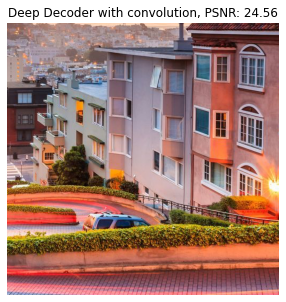

In [0]:
dd_plot(img_np, k=22, convolutions=3)

The number of net parameters is: 25536
tensor(0.0654, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0032, de

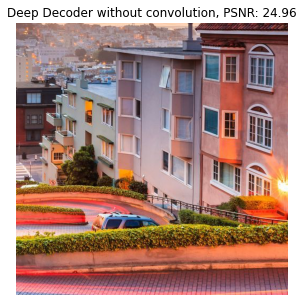

In [0]:
dd_plot(img_np, k=64, convolutions=1)

The number of net parameters is: 49770
tensor(0.0549, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0032, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0026, de

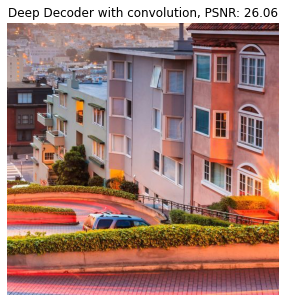

In [0]:
dd_plot(img_np, k=30, convolutions=3)

The number of net parameters is: 48861
tensor(0.0565, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0030, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0022, de

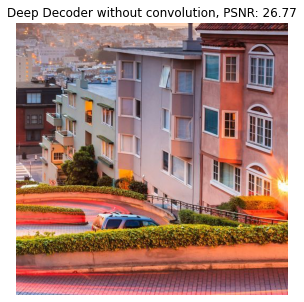

In [0]:
dd_plot(img_np, k=89, convolutions=1)